# Task 3

Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn import preprocessing
import matplotlib.gridspec as gridspec
import cv2
try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Reading image

In [2]:
img = torchvision.io.read_image("task_4_image.jpeg") 
print(img.shape)

torch.Size([3, 1200, 1920])


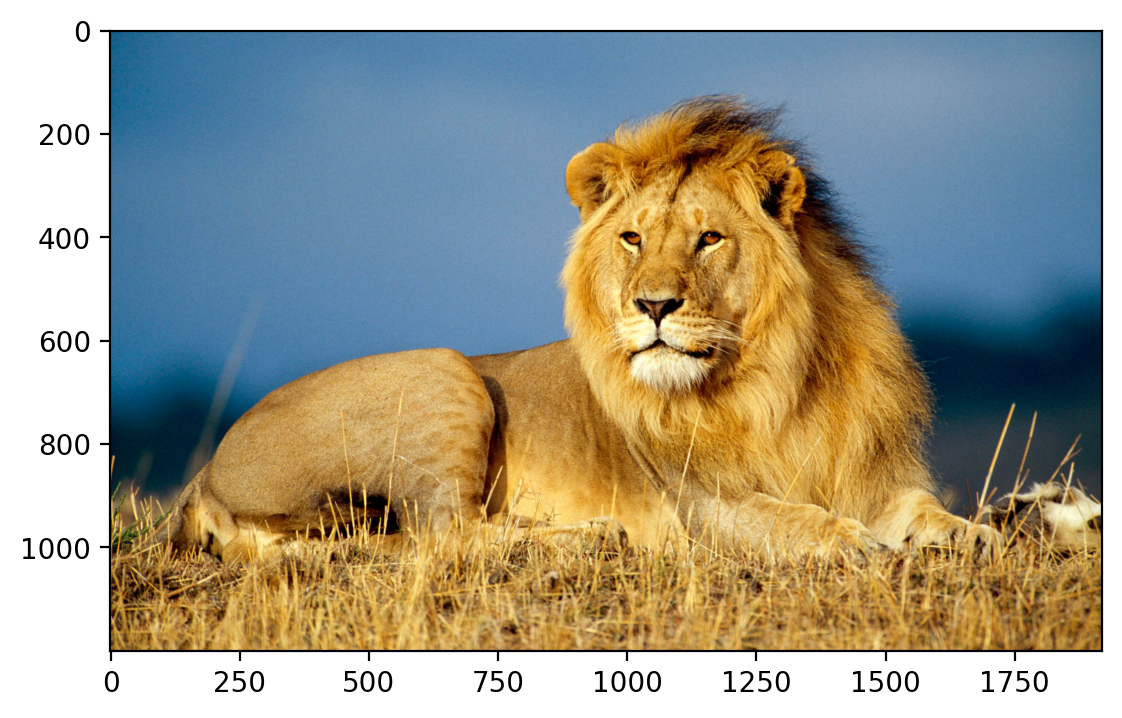

In [3]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [4]:
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [5]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled.shape

torch.Size([3, 1200, 1920])

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_scaled = img_scaled.to(device)

In [7]:
img_scaled

tensor([[[0.1020, 0.0863, 0.0863,  ..., 0.2824, 0.2863, 0.2902],
         [0.0706, 0.0706, 0.0784,  ..., 0.2863, 0.2902, 0.2941],
         [0.0745, 0.0863, 0.0980,  ..., 0.2784, 0.2902, 0.2941],
         ...,
         [0.7176, 0.6078, 0.5216,  ..., 0.5804, 0.5529, 0.5294],
         [0.7412, 0.6471, 0.5451,  ..., 0.5961, 0.5647, 0.5255],
         [0.7255, 0.6549, 0.5608,  ..., 0.6235, 0.5765, 0.5373]],

        [[0.3608, 0.3608, 0.3686,  ..., 0.4510, 0.4549, 0.4588],
         [0.3725, 0.3725, 0.3804,  ..., 0.4549, 0.4588, 0.4627],
         [0.3765, 0.3765, 0.3804,  ..., 0.4471, 0.4588, 0.4627],
         ...,
         [0.5725, 0.4431, 0.3569,  ..., 0.4078, 0.4000, 0.3804],
         [0.6000, 0.4863, 0.3843,  ..., 0.4314, 0.4118, 0.3882],
         [0.6235, 0.5373, 0.4392,  ..., 0.4588, 0.4314, 0.4078]],

        [[0.5569, 0.5529, 0.5647,  ..., 0.5765, 0.5804, 0.5843],
         [0.5451, 0.5529, 0.5608,  ..., 0.5804, 0.5843, 0.5882],
         [0.5412, 0.5529, 0.5686,  ..., 0.5725, 0.5843, 0.

torch.Size([3, 400, 400])


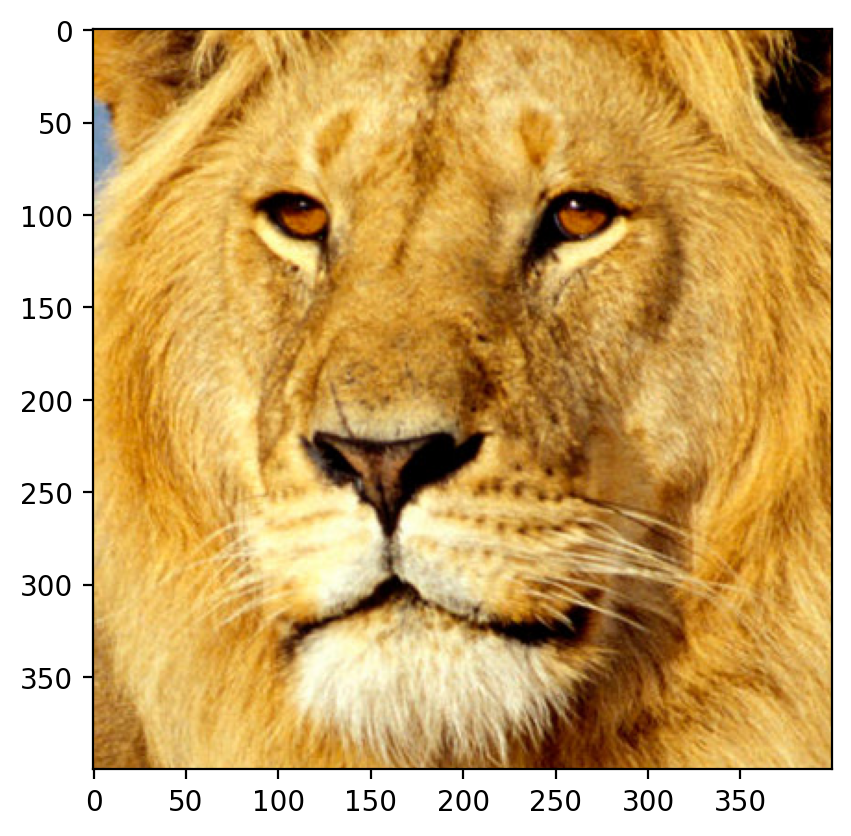

In [8]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 300, 900, 400, 400)
print(crop.shape)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
crop = crop.to(device)

Resizing to 200x200

Original Dimensions :  torch.Size([3, 400, 400])
Resized Dimensions :  torch.Size([3, 200, 200])


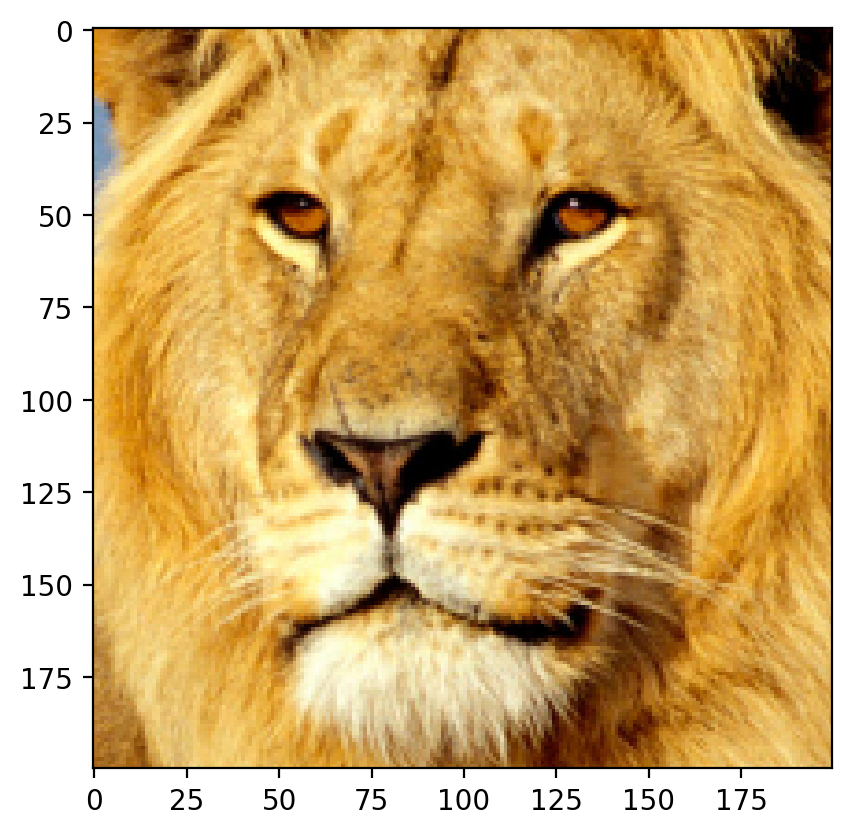

In [9]:
print('Original Dimensions : ',crop.shape)
dim = (200, 200)
resized0 = cv2.resize(crop[0].cpu().numpy(), dim, interpolation = cv2.INTER_AREA)
resized1 = cv2.resize(crop[1].cpu().numpy(), dim, interpolation = cv2.INTER_AREA)
resized2 = cv2.resize(crop[2].cpu().numpy(), dim, interpolation = cv2.INTER_AREA)
resized = torch.Tensor(np.array([resized0, resized1, resized2]))
print('Resized Dimensions : ',resized.shape)
plt.imshow(rearrange(resized, 'c h w -> h w c').numpy())

In [10]:
num_channels, height, width = resized.shape
print(num_channels, height, width)

3 200 200


In [11]:
def create_coordinate_map(img):
    
    num_channels, height, width = img.shape                 #extracting number of channels, height and width of the img
    
    #creating a 2D grid of (x,y) coordinates (h, w)
   
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    
    #flatening and combining the coordinates 
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)
    X = torch.stack([h_coords, w_coords], dim=1).float()

    #move X to GPU if available for faster computations
    X = X.to(device)

    #reshaping the image
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [12]:
image_X, image_Y = create_coordinate_map(resized)
image_X.shape, image_Y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [13]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(image_X.cpu())

#scaling the X coordinates
image_X_scaled = scaler_X.transform(image_X.cpu())

#moving the scaled X coordinates to the GPU
image_X_scaled = torch.tensor(image_X_scaled).to(device)

#setting to dtype float32
image_X_scaled = image_X_scaled.float()

In [14]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)

In [15]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [16]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    Y = Y.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [17]:
train(net, 0.01, image_X_scaled, image_Y, 1000)

Epoch 0 loss: 0.316676
Epoch 100 loss: 0.036485
Epoch 200 loss: 0.035849
Epoch 300 loss: 0.035849
Epoch 400 loss: 0.035849
Epoch 500 loss: 0.035849
Epoch 600 loss: 0.035849
Epoch 700 loss: 0.035849
Epoch 800 loss: 0.035849
Epoch 900 loss: 0.035849


0.03584926575422287

In [18]:
#creating RFF features
def create_rff_features(X, num_features, sigma, random_state=42):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=random_state)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [19]:
X_rff = create_rff_features(image_X_scaled, 5000, 0.008)

In [20]:
X_rff.shape

torch.Size([40000, 5000])

In [21]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, image_Y, 1000)

Epoch 0 loss: 0.388535
Epoch 100 loss: 0.077924
Epoch 200 loss: 0.031517
Epoch 300 loss: 0.026373
Epoch 400 loss: 0.025237
Epoch 500 loss: 0.024644
Epoch 600 loss: 0.024275
Epoch 700 loss: 0.024030
Epoch 800 loss: 0.023857
Epoch 900 loss: 0.023727


0.02362457662820816

In [22]:
def get_reconstructed_trained_image(original_img, net, X):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
    return outputs

In [23]:
outputs = get_reconstructed_trained_image(resized, net, X_rff)

Reconstructed image from linear regression with RFF

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


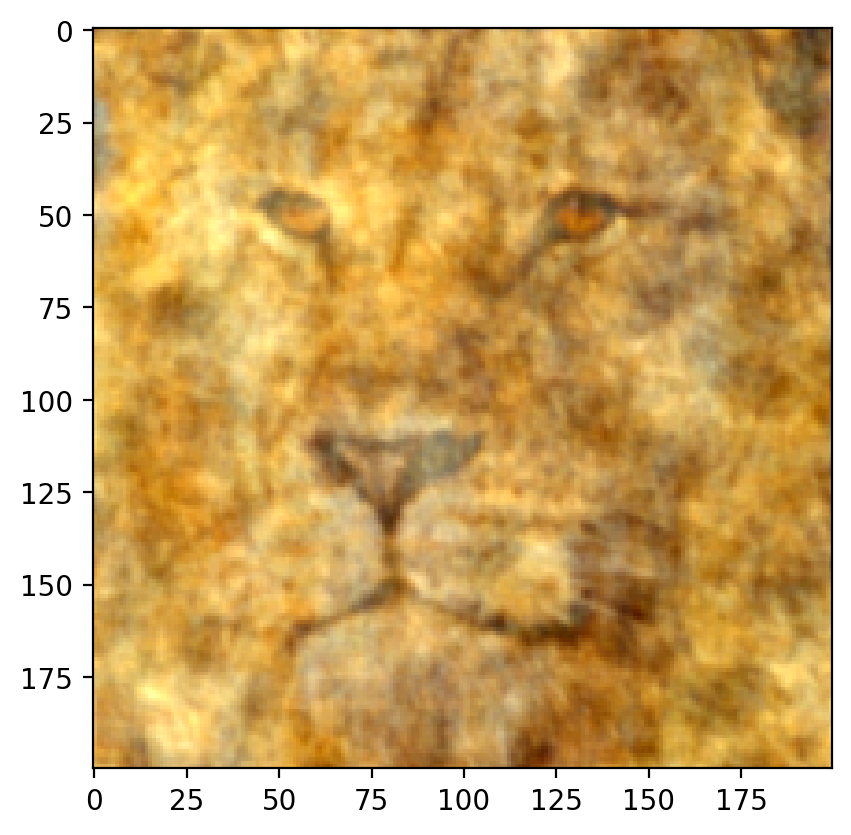

In [24]:
plt.imshow(outputs.cpu())

Predicting the super-resolution image of 400x400

In [25]:
super_image_X, super_image_Y = create_coordinate_map(crop)
super_image_X.shape, super_image_Y.shape

(torch.Size([160000, 2]), torch.Size([160000, 3]))

In [26]:
super_scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(super_image_X.cpu())

#scaling the X coordinates
super_image_X_scaled = super_scaler_X.transform(super_image_X.cpu())

#moving the scaled X coordinates to the GPU
super_image_X_scaled = torch.tensor(super_image_X_scaled).to(device)

#setting to dtype float32
super_image_X_scaled = super_image_X_scaled.float()

In [27]:
super_X_rff = create_rff_features(super_image_X_scaled, 5000, 0.008)

In [28]:
super_X_rff.shape

torch.Size([160000, 5000])

In [29]:
super_outputs = get_reconstructed_trained_image(crop, net, super_X_rff)

In [30]:
super_outputs.shape

torch.Size([400, 400, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


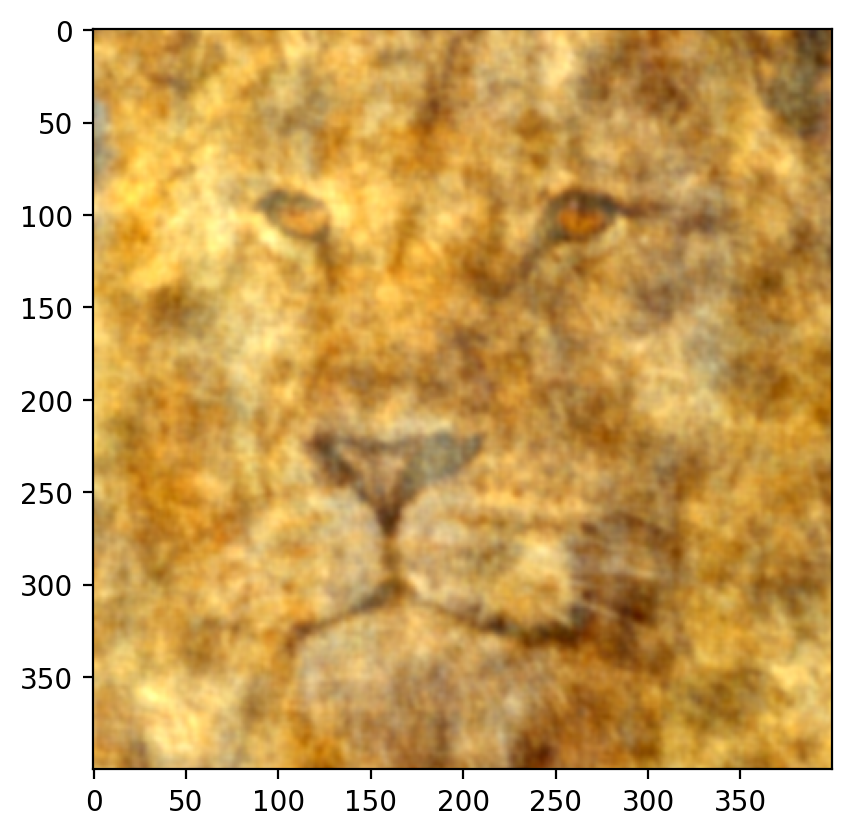

In [31]:
plt.imshow(super_outputs.cpu())

## Qualitative Analysis

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


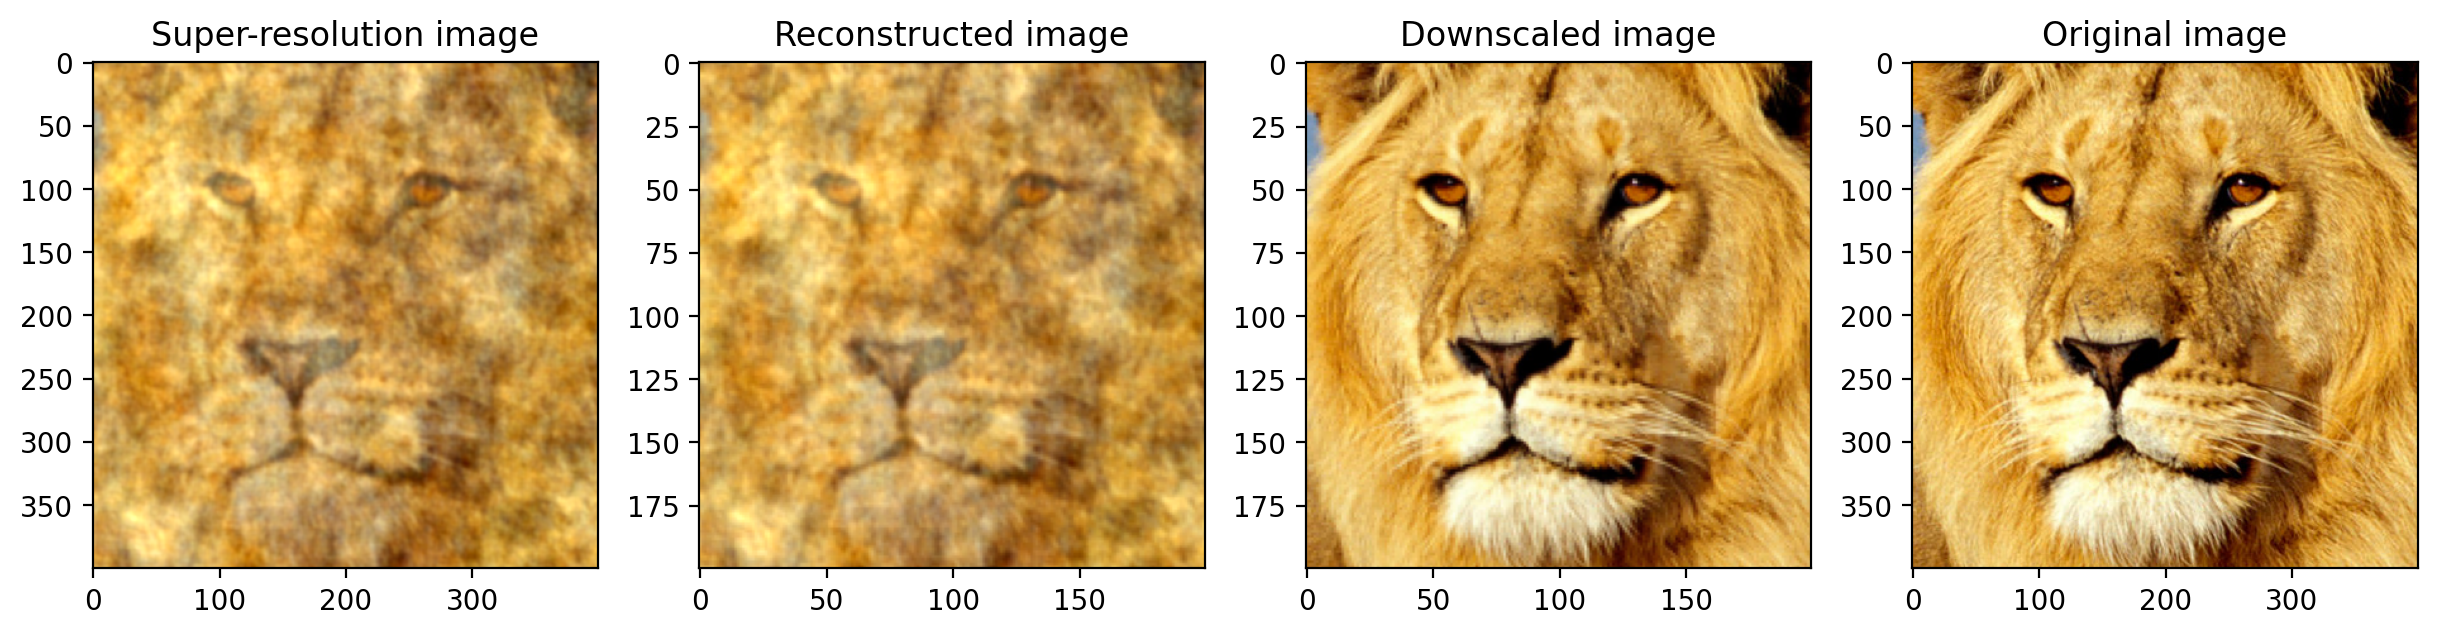

In [41]:
#comparing the reconstructed image with the original image
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
ax[0].set_title("Super-resolution image")
ax[0].imshow(super_outputs.cpu())
ax[1].set_title("Reconstructed image")
ax[1].imshow(outputs.cpu())
ax[2].set_title("Downscaled image")
ax[2].imshow(rearrange(resized.cpu(), 'c h w -> h w c'))
ax[3].set_title("Original image")
ax[3].imshow(rearrange(crop.cpu(), 'c h w -> h w c'))

In [33]:
def cal_rmse(original_image, reconstructed_image):
    original_image = original_image.numpy().astype(np.float32)
    reconstructed_image = reconstructed_image.numpy().astype(np.float32)

    mse = np.mean((original_image-reconstructed_image)**2)
    rmse = np.sqrt(mse)
    return rmse

def cal_psnr(original_image, reconstructed_img):
    rmse = cal_rmse(original_image, reconstructed_img)
    psnr = 20 * np.log10(255.0/rmse)
    return psnr

## Quantitative Analysis

In [42]:
rmse = cal_rmse((crop*256).cpu(), rearrange((super_outputs*256).cpu(), 'h w c -> c h w'))
psnr = cal_psnr((crop*256).cpu(), rearrange((super_outputs*256).cpu(), 'h w c -> c h w'))
print("RMSE = ", rmse, " PSNR = ", psnr)

RMSE =  40.059807  PSNR =  16.07662659449559
